# Particle filter implementation on ship tracking
### In this project, the particle filter estimation on the ship's locations in a 2D-domain is implemented, where 10000 particles and 100 paritcles are studied to compare the performance over the size of the particle filter


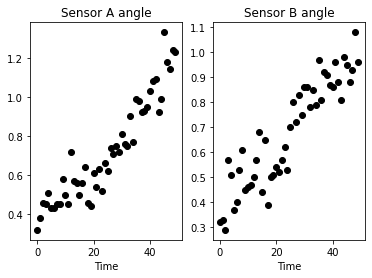

In [180]:
import numpy as np
import matplotlib.pyplot as plt
N = 50 # number of time points
yA = np.loadtxt('sensorA.txt')
yB = np.loadtxt('sensorB.txt')
y = np.vstack((yA, yB))
plt.figure()
plt.subplot(121)
plt.plot(yA, 'ko')
plt.title("Sensor A angle")
plt.xlabel("Time")
plt.subplot(122)
plt.plot(yB, 'ko')
plt.title("Sensor B angle")
plt.xlabel("Time")
plt.show()

## Set up the model

A surface vessel has state $\boldsymbol{x}_t = (\mathcal{E}_t, \mathcal{N}_t, \mathcal{v}_t, \mathcal{u}_t)$, which represents the
position along north and east, and the velocity along north and east respectively.

The initial state is $\boldsymbol{x}_t \sim \mathcal{N}_4(\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1)$, where

$\boldsymbol{\mu}_1 = \begin{bmatrix} 10 \\ 30 \\  10 \\  -10 \end{bmatrix}$

$\boldsymbol{\Sigma}_1 = \begin{bmatrix}10^2 & 0 & 0 & 0 \\ 0 & 10^2 & 0 & 0 \\ 0 & 0 & 5^2 & 0 \\ 0 & 0 & 0 & 5^2\end{bmatrix}$

The evolution model can be expressed as

$\boldsymbol{x}_{t + 1} = \boldsymbol{A}\boldsymbol{x}_t + \boldsymbol{\epsilon}_{t + 1}$, where
$\boldsymbol{A} = \begin{bmatrix}1 & 0 & \delta & 0 \\ 0 & 1 & 0 & \delta \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}$, and $\delta = \frac{1}{60}$

$\boldsymbol{\epsilon}_{t + 1} \sim \mathcal{N}(\boldsymbol{0}, \begin{bmatrix}0.1^2 & 0 & 0 & 0 \\ 0 & 0.1^2 & 0 & 0 \\ 0 & 0 & 0.5^2 & 0 \\ 0 & 0 & 0 & 0.5^2\end{bmatrix})$

While the observation model can be formulated as

$\boldsymbol{y}_t = \begin{bmatrix}\arctan(E_t/N_t) \\ \arctan[(40 - N_t)/(40 - E_t)]\end{bmatrix} + \boldsymbol{\epsilon}_t$, where

$\boldsymbol{\epsilon}_t \sim \mathcal{N}_2(\boldsymbol{0}, \begin{bmatrix} 0.1^2 & 0 \\ 0 & 0.1^2\end{bmatrix})$

In [181]:
A = np.eye(4)
delta = 1 / 60
A[0, 2] = delta
A[1, 3] = delta

In [198]:
mu_prior = np.vstack((10, 30, 10, -10))
Sigma_prior = np.diagflat(np.vstack((10**2, 10**2, 5**2, 5**2)))
Sigma_PP = np.diagflat(np.vstack((.1**2, .1**2, .5**2, .5**2)))
Sigma_noise = np.diagflat(np.vstack((.1**2, .1**2)))
B = 100
L = np.linalg.cholesky(Sigma_prior)
xB = np.zeros([4, B])
xB = mu_prior * np.ones([1, B]) + np.dot(L, np.random.randn(4 * B).reshape(4, B))
mm = np.zeros([4, N])
mvar = np.zeros([4, N])
mlow = np.zeros([4, N])
mhigh = np.zeros([4, N])

In [199]:
for i in range(N):
    # ya = np.divide(np.arctan(xB[0, :]), np.arctan(xB[1, :]))
    # yb = np.divide(np.arctan(40 - xB[1, :]), np.arctan((40 - xB[0, :])))
    ya = np.arctan(np.divide(xB[0, :], xB[1, :]))
    yb = np.arctan(np.divide((40 - xB[1, :]), (40 - xB[0, :])))
    l = np.zeros([B, 1])
    for ii in range(B):
        y_est = np.vstack((ya[ii], yb[ii]))
        ydiff = y[:, i].reshape(-1, 1) - y_est
        l[ii] = np.exp(-(np.linalg.solve(Sigma_noise, ydiff).T.dot(ydiff)) / 2)

    # reweighting
    nw = l / np.sum(l) # updated weights pdf
    Fw = np.cumsum(nw) # cdf to be used for resampling

    # resampling using the weights
    xBupd = np.zeros([4, B])
    for kk in range(B):
        Ur = np.random.rand()
        # ind = np.argwhere(Fw > Ur)
        ind = np.argwhere(Fw > Ur)[:, 0][0]
        # print(ind)
        xBupd[:, kk] = xB[:, ind]

    mm[:, i] = np.mean(xBupd, axis = 1)
    mvar[:, i] = np.var(xBupd, axis = 1)

    for ik in range(4):
        ms = np.sort(xBupd[ik, :])
        mlow[ik, i] = ms[int(np.ceil(.025 * B))]
        mhigh[ik, i] = ms[int(np.floor(.975 * B))]
    if i < N:
        xB = np.dot(A, xBupd) + np.dot(np.linalg.cholesky(Sigma_PP), np.random.randn(4 * B).reshape(4, B))
print(mm)

[[  9.98393845  10.75543777  12.79787254  13.20860132  15.22500115
   15.87207392  15.27201825  15.13548237  14.61109508  16.68068771
   16.58851435  14.78726219  18.89516553  19.41511616  19.84784422
   19.32582001  20.00935021  20.37456442  17.06423775  12.7925034
   12.81742284  12.7168858   12.79485015  12.82161756  13.0419624
   13.3513434   13.8763041   14.2550751   14.70080357  14.9275663
   15.28044714  15.50570876  15.80088451  16.06476697  16.32590927
   16.72603337  16.99139005  17.23413886  17.42763662  17.61013018
   17.86680776  18.1436532   18.38375375  18.52171264  18.73347192
   19.05759294  19.28133383  19.53786591  19.75676869  19.92331867]
 [ 28.57134375  29.04128411  29.74009609  28.49446533  29.26801285
   29.38042355  28.8651943   28.44122265  27.6066555   28.15712036
   27.819451    26.79337385  27.99314005  27.743397    27.55460181
   27.1236761   27.00554695  26.84494751  25.41181349  23.66546565
   23.44249093  23.15655304  22.95354751  22.70511846  22.513518

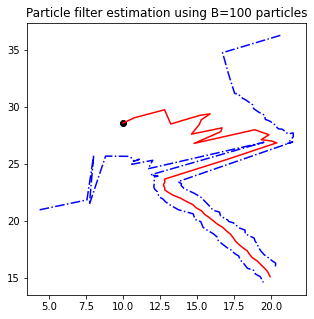

In [200]:
plt.figure(figsize = (5, 5))
plt.plot(mm[0,0], mm[1, 0], 'ko')
plt.title("Particle filter estimation using B={:d} particles".format(B))
plt.plot(mm[0, :], mm[1, :], 'r')
plt.plot(mlow[0, :], mlow[1, :], 'b-.')
plt.plot(mhigh[0, :], mhigh[1, :], 'b-.')

plt.show()

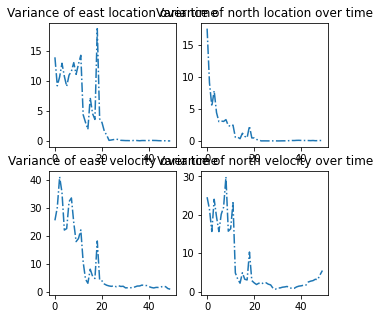

In [201]:
plt.figure(figsize = (5, 5))
plt.subplot(221)
plt.plot(mvar[0, :], '-.')
plt.title("Variance of east location over time")
plt.subplot(222)
plt.plot(mvar[1, :], '-.')
plt.title("Variance of north location over time")
plt.subplot(223)
plt.plot(mvar[2, :], '-.')
plt.title("Variance of east velocity over time")
plt.subplot(224)
plt.plot(mvar[3, :], '-.')
plt.title("Variance of north velocity over time")
plt.show()

From the variances plot, one can tell the estimation variances for locations along east and north tend to increase over time, while the estimation variances for velocities tend to keep stable when the particle size is around 10000.


In [38]:
B = 100
L = np.linalg.cholesky(Sigma_prior)
xB = np.zeros([4, B])
xB = mu_prior * np.ones([1, B]) + np.dot(L, np.random.randn(4 * B).reshape(4, B))
mm = np.zeros([4, N])
mvar = np.zeros([4, N])
mlow = np.zeros([4, N])
mhigh = np.zeros([4, N])
for i in range(N):
    yPB = np.vstack((np.divide(np.arctan(xB[0, :]), np.arctan(xB[1, :])),
                     np.divide(np.arctan(40 - xB[1, :]), np.arctan(40 - xB[0, :]))))

    l = -.5 * np.linalg.inv(Sigma_noise[0, 0].reshape(-1, 1)) * np.multiply((
            np.dot(y[:, i].reshape(-1, 1), np.ones([1, B])) - yPB),
            (np.dot(y[:, i].reshape(-1, 1), np.ones([1, B])) - yPB))
    # why here only Sigma_noise used in the loglikelihood instead of the sampling
    # reweighting
    w = l[0, :] + l[1, :]
    ew = np.exp(w)
    nw = ew / np.sum(ew) # updated weights pdf
    Fw = np.cumsum(nw) # cdf to be used for resampling
    # resampling using the weights
    xBupd = np.zeros([4, B])
    for kk in range(B):
        Ur = np.random.rand()
        ind = np.argwhere(Fw > Ur)[:, 0][0]
        xBupd[:, kk] = xB[:, ind]
    mm[:, i] = np.mean(xBupd, axis = 1)
    mvar[:, i] = np.var(xBupd, axis = 1)
    for ik in range(4):
        ms = np.sort(xBupd[ik, :])
        mlow[ik, i] = ms[int(np.ceil(.05 * B))]
        mhigh[ik, i] = ms[int(np.floor(.95 * B))]
    if i < N:
        xB = np.dot(A, xBupd) + np.dot(np.linalg.cholesky(Sigma_PP), np.random.randn(4 * B).reshape(4, B))

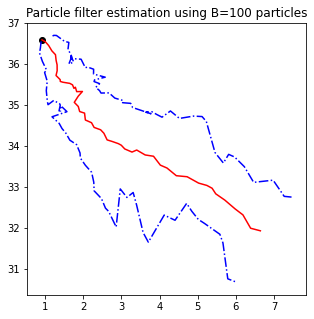

In [39]:
plt.figure(figsize = (5, 5))
plt.plot(mm[0,0], mm[1, 0], 'ko')
plt.title("Particle filter estimation using B={:d} particles".format(B))
plt.plot(mm[0, :], mm[1, :], 'r')
plt.plot(mlow[0, :], mlow[1, :], 'b-.')
plt.plot(mhigh[0, :], mhigh[1, :], 'b-.')
plt.show()

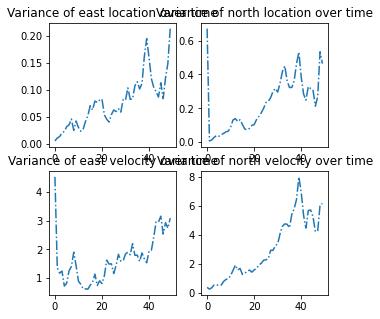

In [40]:
plt.figure(figsize = (5, 5))
plt.subplot(221)
plt.plot(mvar[0, :], '-.')
plt.title("Variance of east location over time")
plt.subplot(222)
plt.plot(mvar[1, :], '-.')
plt.title("Variance of north location over time")
plt.subplot(223)
plt.plot(mvar[2, :], '-.')
plt.title("Variance of east velocity over time")
plt.subplot(224)
plt.plot(mvar[3, :], '-.')
plt.title("Variance of north velocity over time")
plt.show()



When only having 100 particles, the estimation variances for velocities tend to become very large compared to the estimation variances for locations

## To sum up, the particle filter provides an efficient way of estimating the location and velocities in this case, but it is important to choose the right size of the particles to both achieve the estimation accuracy and the computational efficency.

